In [228]:
import spacy
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import json
import spacy_stanza
import matplotlib.pyplot as plt
import re
# import torch
# import stanza
# from wordcloud import WordCloud
# from thinc.api import get_current_ops

In [229]:
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# get_current_ops()

In [230]:
with open('corpus.json', 'r') as file:
  raw_corpus = json.load(file)

flat_corpus = []
for video in raw_corpus:
  youtube_id = video['id']
  youtube_title = video['title']
  youtube_text = video['text']
  flat_corpus.append({
    'id': youtube_id,
    'title': youtube_title,
    'text': youtube_text
  })

df = pd.DataFrame(flat_corpus)
df.reset_index(drop=True, inplace=True)
nlp = spacy_stanza.load_pipeline('id')


# Computation with GPU
# spacy.require_gpu()

# Download indonesian stanza stanford nlp model
# stanza.download('id')

# total_word_count = 0
# for video in flat_corpus:
#     words = video['text'].split()
#     total_word_count += len(words)

# print(f"Total number of words in the corpus: {total_word_count}")


2024-07-03 22:16:23 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-07-03 22:16:25 INFO: Loading these models for language: id (Indonesian):
| Processor    | Package      |
-------------------------------
| tokenize     | gsd          |
| mwt          | gsd          |
| pos          | gsd_charlm   |
| lemma        | gsd_nocharlm |
| constituency | icon_charlm  |
| depparse     | gsd_charlm   |

2024-07-03 22:16:25 WARNING: GPU requested, but is not available!
2024-07-03 22:16:25 INFO: Using device: cpu
2024-07-03 22:16:25 INFO: Loading: tokenize
2024-07-03 22:16:25 INFO: Loading: mwt
2024-07-03 22:16:25 INFO: Loading: pos
2024-07-03 22:16:25 INFO: Loading: lemma
2024-07-03 22:16:25 INFO: Loading: constituency
2024-07-03 22:16:25 INFO: Loading: depparse
2024-07-03 22:16:25 INFO: Done loading processors!


Total number of words in the corpus: 16997


In [231]:
def custom_tokenizer(doc):
    stripped_text = doc.strip()
    duplicated_letter_pattern = re.compile(r'^(.)\1+$')
    tokens = []
    
    for t in nlp(stripped_text):
        # Fix this later. Because this is hardcoded for text with length = 2 to remove all of nonsense < 2 length char
        if t.text == 'ya' and t.text == 'oh':
            tokens.append(t.text)
        if len(t.text) > 2 and (not t.is_punct) and (not t.is_stop) and t.is_alpha and (not duplicated_letter_pattern.match(t.text)):
            tokens.append(t.lemma_)
    
    return tokens

In [232]:
custom_stop_words = ["[Musik]", "[Tepuk tangan]"]

for word in custom_stop_words:
  nlp.Defaults.stop_words.add(word)
  
transcripts = df["text"].tolist()

# N-gram vectorizer
# vectorizer = CountVectorizer(tokenizer=custom_tokenizer, binary=True, lowercase=False, ngram_range=(1,2))

vectorizer = CountVectorizer(tokenizer=custom_tokenizer, binary=True)
bow = vectorizer.fit_transform(transcripts)

# bow.toarray()
# print(cosine_similarity(bow))

/opt/homebrew/Caskroom/miniconda/base/envs/analysis/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/analysis/lib/python3.12/site-packages/spacy/language.py:1037: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
/opt/homebrew/Caskroom/miniconda/base/envs/analysis/lib/python3.12/site-packages/spacy/language.py:1037: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['jadi', 'waktu', 'gempa', 'terakhir', 'itu', 'terjadi', 'rengkahan', 'di', 'laut', 'itu', 'itu', 'keluar', 'ular', 'hitam', 'dari', 'dalam', 'tanah', 'jadi', 'disebut', 'ular', 'bumi', 'itu', 'mau', 'mengarah', '

[[1.         0.10600587 0.32037314 0.17057223 0.2979682  0.22390035
  0.16418368 0.15174639 0.09558989 0.08874701 0.07284556 0.13601015
  0.0494591 ]
 [0.10600587 1.         0.130069   0.07753403 0.15229146 0.13380139
  0.13769562 0.11287097 0.06188422 0.15512631 0.14147911 0.19437898
  0.10806572]
 [0.32037314 0.130069   1.         0.17523224 0.30579882 0.19647714
  0.15591576 0.15889001 0.09467621 0.09064557 0.12078563 0.15726772
  0.06314648]
 [0.17057223 0.07753403 0.17523224 1.         0.22384671 0.30233271
  0.23620226 0.22240783 0.17796712 0.17348856 0.14530955 0.1481102
  0.12661255]
 [0.2979682  0.15229146 0.30579882 0.22384671 1.         0.28592222
  0.15677122 0.18471053 0.10823444 0.1229636  0.12093154 0.18122317
  0.08289697]
 [0.22390035 0.13380139 0.19647714 0.30233271 0.28592222 1.
  0.19310428 0.22006198 0.16087236 0.14002142 0.18389243 0.17815126
  0.07803456]
 [0.16418368 0.13769562 0.15591576 0.23620226 0.15677122 0.19310428
  1.         0.28429748 0.23177627 0.1868

In [233]:
feature_names = vectorizer.get_feature_names_out()
# check for vocabulary with length of 2
short_feature = [text for text in feature_names if len(text) == 2]
df = pd.DataFrame(short_feature, columns=["Feature"])
df

# print(vectorizer.get_feature_names_out()[0:20])
# print(len(vectorizer.get_feature_names_out()))
# tfidf_scores = np.asarray(bow.sum(axis=0)).flatten()
# np.set_printoptions(threshold=np.inf)
# print(tfidf_scores)

,Feature


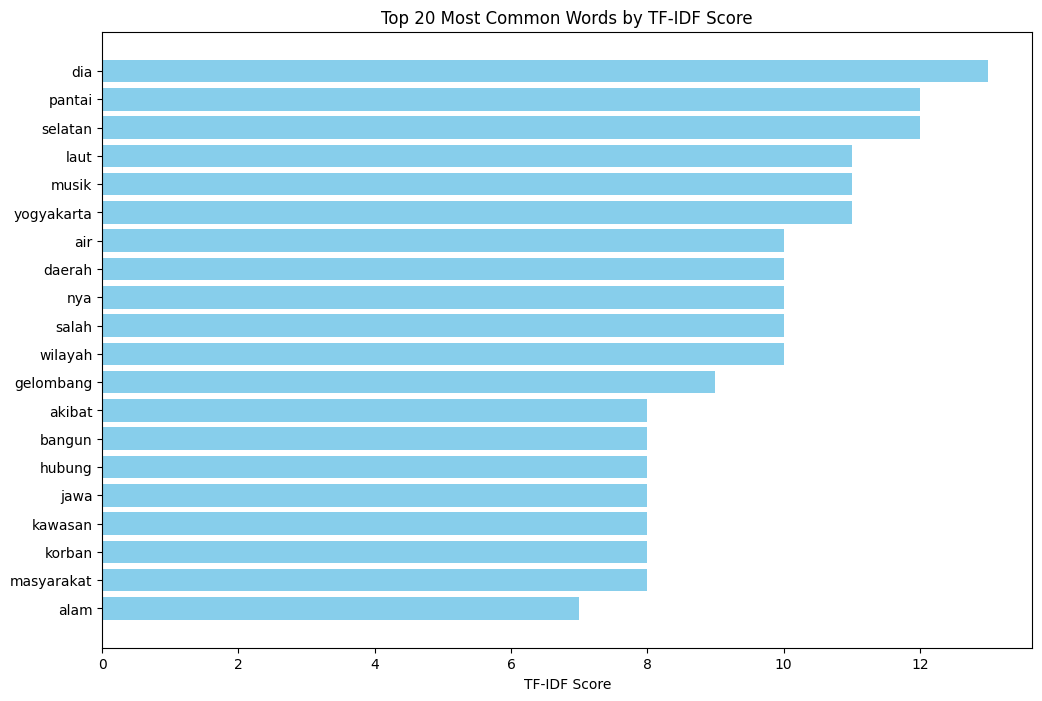

In [234]:
tfidf_scores = np.asarray(bow.sum(axis=0)).flatten()
tfidf_dict = dict(zip(vectorizer.get_feature_names_out(), tfidf_scores))
sorted_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:20]
words, scores = zip(*sorted_tfidf)

plt.figure(figsize=(12, 8))
plt.barh(words, scores, color='skyblue')
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Most Common Words by TF-IDF Score')
plt.gca().invert_yaxis() 
plt.show()
